# transit fitting (fixed ephemeris)

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dill, corner, os
from jax.config import config
config.update('jax_enable_x64', True)
from jkepler.transit.transitfit import *

In [2]:
kicnum = 11773022 # Kepler-51

## load transit data

In [3]:
#datapath = "../../pykepler/examples/kic%s/kic%s_"%(kicnum, kicnum)
datapath = "data/kic%s_"%kicnum

In [4]:
d = pd.read_csv(datapath+"long_transits.csv")

In [5]:
t, f, e = np.array(d.time), np.array(d.flux), np.array(d.error)

## initialization using KOI info

In [6]:
dkoi = pd.read_csv(datapath+"koiinfo.csv")

In [7]:
def init_params_from_koitable(dkoi):
    t0, period, b, depth, t0err, perr = np.array(dkoi[['koi_time0bk', 'koi_period', 'koi_impact', 'koi_depth', 'koi_time0bk_err1', 'koi_period_err1']]).T
    rp_over_r = np.sqrt(depth * 1e-6)
    rstar = dkoi.koi_srad[0]
    return t0, period, b, rstar, rp_over_r, t0err, perr

In [8]:
t0, period, b, rstar, rp_over_r, _, _ = init_params_from_koitable(dkoi)
ecc, omega = 0 * t0, 0 * t0

## optimization

In [9]:
tf = TransitFit(t, exposure_time=29.4/1440., supersample_factor=10)

In [10]:
# fit without TTVs
popt = tf.optimize_transit_params(f, e, t0, period, ecc, omega, b, rstar, rp_over_r, fit_ttvs=False)

# initial objective function: -24523.9

# optimizing t0 and period...
ScipyMinimizeInfo(fun_val=DeviceArray(-24795.42481448, dtype=float64, weak_type=True), success=True, status=1, iter_num=11)

# optimizing radius ratios and GP parameters...
ScipyMinimizeInfo(fun_val=DeviceArray(-26788.64980577, dtype=float64, weak_type=True), success=False, status=3, iter_num=19)

# optimizing radius ratios, impact parameters, stellar radius, and GP parameters...
ScipyMinimizeInfo(fun_val=DeviceArray(-27398.94127217, dtype=float64, weak_type=True), success=False, status=3, iter_num=18)

# optimizing all parameters...
ScipyMinimizeInfo(fun_val=DeviceArray(-29379.30276377, dtype=float64, weak_type=True), success=False, status=3, iter_num=26)

# optimizing all parameters with mean...
ScipyMinimizeInfo(fun_val=DeviceArray(-29381.0172331, dtype=float64, weak_type=True), success=False, status=3, iter_num=24)


In [11]:
pd.DataFrame(popt)

,b,ecc,lna,lnc,lnjitter,meanflux,omega,period,q1,q2,rp,rstar,t0
0,0.455692,0.0,-8.121705097193706,-3.329211409347752,-9.345924611110382,1.4154121915845961e-05,0.0,45.155242,0.3600000000000001,0.3333333333333333,0.073817,0.9352282027269794,159.107280
1,0.998961,0.0,-8.121705097193706,-3.329211409347752,-9.345924611110382,1.4154121915845961e-05,0.0,85.316543,0.3600000000000001,0.3333333333333333,0.073983,0.9352282027269794,295.314857
2,0.459239,0.0,-8.121705097193706,-3.329211409347752,-9.345924611110382,1.4154121915845961e-05,0.0,130.177030,0.3600000000000001,0.3333333333333333,0.100536,0.9352282027269794,212.036999


## check solution

In [12]:
tpred = np.arange(np.min(t), np.max(t), np.median(np.diff(t))*0.2) # dense time grid
fpred, gppred = compute_prediction(tf, f, e, popt, tpred)

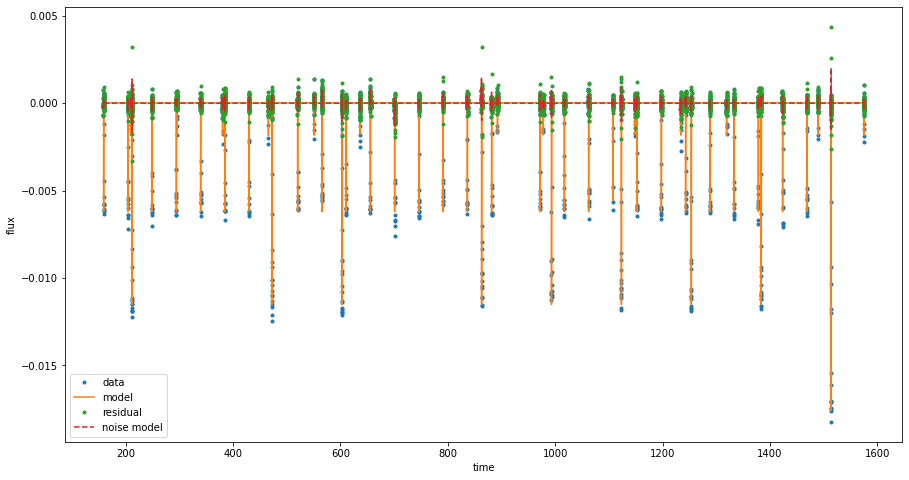

In [13]:
plt.figure(figsize=(15,8))
#plt.xlim(1512, 1515)
plt.xlabel("time")
plt.ylabel("flux")
plt.plot(t, f, '.', label='data')
plt.plot(t, fpred, '-', label='model')
plt.plot(t, f-fpred, '.', label='residual')
plt.plot(tpred, gppred, '--', label='noise model')
plt.legend(loc='best');

In [14]:
from scipy.stats import binned_statistic

def phasefold(time, flux, err, t0, period, pcenter=0.5):
    t_fold = (time - t0  + pcenter * period) % period - pcenter * period
    index = np.argsort(t_fold)
    return t_fold[index], flux[index], err[index]


def binning(x, y, binwidth, statistic='median'):
    bins = np.arange(np.min(x), np.max(x), binwidth)
    vals, _, _ = binned_statistic(x, y, statistic=statistic, bins=bins)
    stds, _, _ = binned_statistic(x, y, statistic="std", bins=bins)
    counts, _, _ = binned_statistic(x, y, statistic="count", bins=bins)
    return 0.5 * (bins[1:] + bins[:-1]), vals, stds / np.sqrt(counts), counts


def check_folded_transits(t, f, e, fmodel, t0s, ps, bin_frac=1e-4):
    for j ,(t0, p) in enumerate(zip(t0s, ps)):
        tp, fp, ep = phasefold(t, f, e, t0, p)
        tbin, fbin, ebin, _ = binning(tp, fp, p*bin_frac)
        tm, fm, _ = phasefold(t, fmodel, fmodel*0, t0, p)
        fmin = np.min(fbin[np.abs(tbin)<0.5])
        plt.figure(figsize=(10,5))
        plt.title("planet %d"%(j+1))
        plt.ylabel("flux")
        plt.xlabel("time (days)")
        plt.ylim(1.5*fmin, -0.5*fmin)
        plt.xlim(-0.5, 0.5)
        plt.plot(tbin, fbin, 'o', mfc='none', label='folded and binned data')
        plt.plot(tm, fm, '.', markersize=3, zorder=-1000, label='model')
        plt.legend(loc='lower right');

/Users/k_masuda/.pyenv/versions/anaconda3-5.3.1/envs/py38/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3237: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


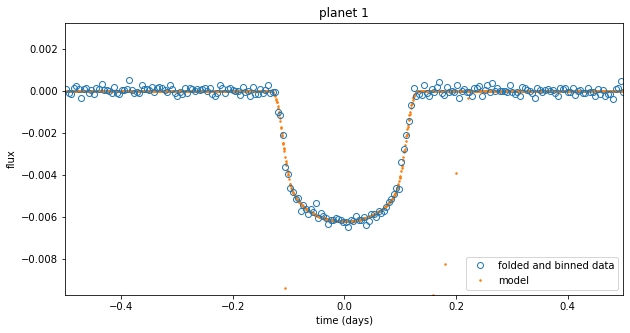

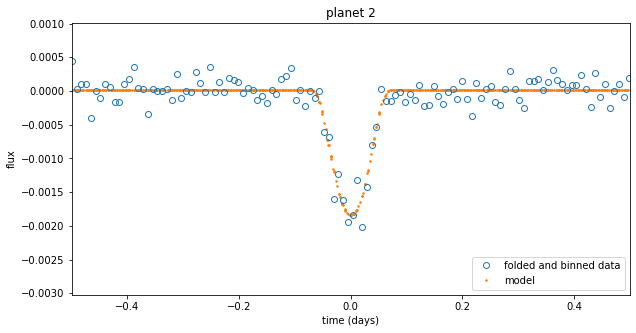

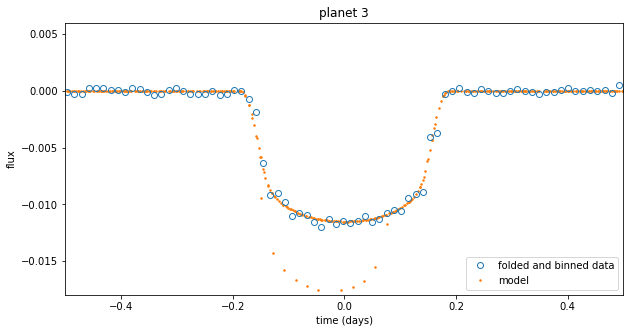

In [17]:
check_folded_transits(t, f, e, fpred, popt['t0'], popt['period'])

## run HMC

In [18]:
import jax.numpy as jnp
import numpyro
from numpyro.infer import init_to_value
import numpyro.distributions as dist
import jax.random as random
from celerite2.jax import terms as jax_terms
import celerite2

def model(tf, flux, error, t0_guess, p_guess, rstar_guess=1., 
          t0_width=1e-2, p_width=1e-3, mean_width=1e-4, rp_min=1e-3, rp_max=0.2):
    # planet parameters
    ones = jnp.ones_like(t0_guess)
    t0 = numpyro.sample("t0", dist.Uniform(low=t0_guess-t0_width, high=t0_guess+t0_width))
    period = numpyro.sample("period", dist.Uniform(low=p_guess-p_width, high=p_guess+p_width))
    ecc = ones * 0.
    omega = ones * 0.
    b = numpyro.sample("b", dist.Uniform(ones*0., ones+rp_max))
    lnrp = numpyro.sample("lnrp", dist.Uniform(ones*jnp.log(rp_min), ones*jnp.log(rp_max)))
    rp = numpyro.deterministic("rp", jnp.exp(lnrp))
    
    # stellar parameters and a/Rstar
    mstar = 1.
    rstar = numpyro.sample("rstar", dist.Uniform(rstar_guess*0.5, rstar_guess*2))
    a = numpyro.deterministic("a", a_over_rstar_kep3(period, mstar, rstar))
    
    # limb darkening
    q1 = numpyro.sample("q1", dist.Uniform(0,1))
    q2 = numpyro.sample("q2", dist.Uniform(0,1))
    u1, u2 = q_to_u(q1, q2)

    # compute flux model
    fluxmodel = tf.compute_flux(t0, period, ecc, omega, b, a, rp, u1, u2)
    numpyro.deterministic("fluxmodel", fluxmodel)
    
    # subtract mean
    if mean_width != 0.:
        mwabs = jnp.abs(mean_width)
        meanflux = numpyro.sample("meanflux", dist.Uniform(-mwabs, mwabs))
    else:
        meanflux = 0.   
    residual = flux - fluxmodel - meanflux
    
    # noise model using GP
    lna = numpyro.sample("lna", dist.Uniform(low=-14, high=-4))
    lnc = numpyro.sample("lnc", dist.Uniform(low=-5, high=1))
    lnjitter = numpyro.sample("lnjitter", dist.Uniform(low=-14, high=-4))
    jitter = numpyro.deterministic("jitter", jnp.exp(lnjitter))
    
    kernel = jax_terms.Matern32Term(sigma=jnp.exp(lna), rho=jnp.exp(lnc))
    gp = celerite2.jax.GaussianProcess(kernel, mean=0.0)
    gp.compute(tf.t, diag=error**2 + jitter**2)
    
    numpyro.sample("obs", gp.numpyro_dist(), obs=residual)

In [19]:
pdic_init = dict(popt)

In [20]:
pdic_init

{'b': DeviceArray([0.455692  , 0.99896126, 0.4592386 ], dtype=float64),
 'ecc': DeviceArray([0., 0., 0.], dtype=float64),
 'lna': DeviceArray(-8.1217051, dtype=float64),
 'lnc': DeviceArray(-3.32921141, dtype=float64),
 'lnjitter': DeviceArray(-9.34592461, dtype=float64),
 'meanflux': DeviceArray(1.41541219e-05, dtype=float64),
 'omega': DeviceArray([0., 0., 0.], dtype=float64),
 'period': DeviceArray([ 45.15524247,  85.31654279, 130.17702962], dtype=float64),
 'q1': DeviceArray(0.36, dtype=float64),
 'q2': DeviceArray(0.33333333, dtype=float64),
 'rp': DeviceArray([0.07381671, 0.07398256, 0.10053618], dtype=float64),
 'rstar': DeviceArray(0.9352282, dtype=float64),
 't0': DeviceArray([159.10728046, 295.31485684, 212.03699911], dtype=float64)}

In [21]:
init_strategy = init_to_value(values=pdic_init)

In [22]:
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.95, init_strategy=init_strategy)

In [23]:
nw, ns = 500, 500 # 1-2hr

In [24]:
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)

In [25]:
output = "transit_mcmc.pkl"

In [26]:
if os.path.exists(output):
    print (output + " loaded.")
    mcmc = dill.load(open(output, 'rb'))
else:
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, tf, f, e, pdic_init['t0'], pdic_init['period'])
    with open(output, "wb") as f:
        dill.dump(mcmc, f)

transit_mcmc.pkl loaded.


In [27]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      b[0]      0.37      0.15      0.41      0.05      0.53     47.26      1.00
      b[1]      1.00      0.04      0.99      0.95      1.06     42.63      1.03
      b[2]      0.37      0.14      0.41      0.11      0.55     47.87      1.00
       lna     -8.09      0.04     -8.09     -8.16     -8.02    193.06      1.00
       lnc     -3.39      0.12     -3.40     -3.57     -3.19    176.24      1.00
  lnjitter    -10.99      1.53    -10.83    -13.22     -8.74    123.14      1.00
   lnrp[0]     -2.62      0.02     -2.62     -2.65     -2.59     63.56      1.00
   lnrp[1]     -2.55      0.30     -2.63     -2.99     -2.08     47.49      1.03
   lnrp[2]     -2.31      0.02     -2.31     -2.34     -2.29     61.55      1.00
  meanflux      0.00      0.00      0.00     -0.00      0.00    491.11      1.00
 period[0]     45.16      0.00     45.16     45.16     45.16    247.26      1.00
 period[1]     85.32      0

## corner plots

In [28]:
samples = mcmc.get_samples()

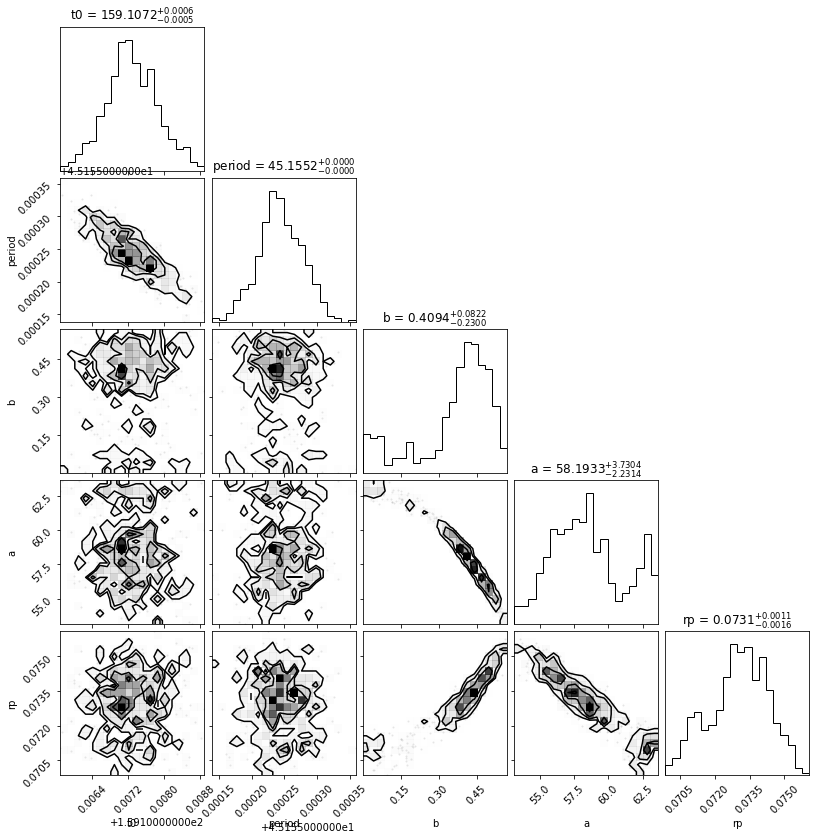

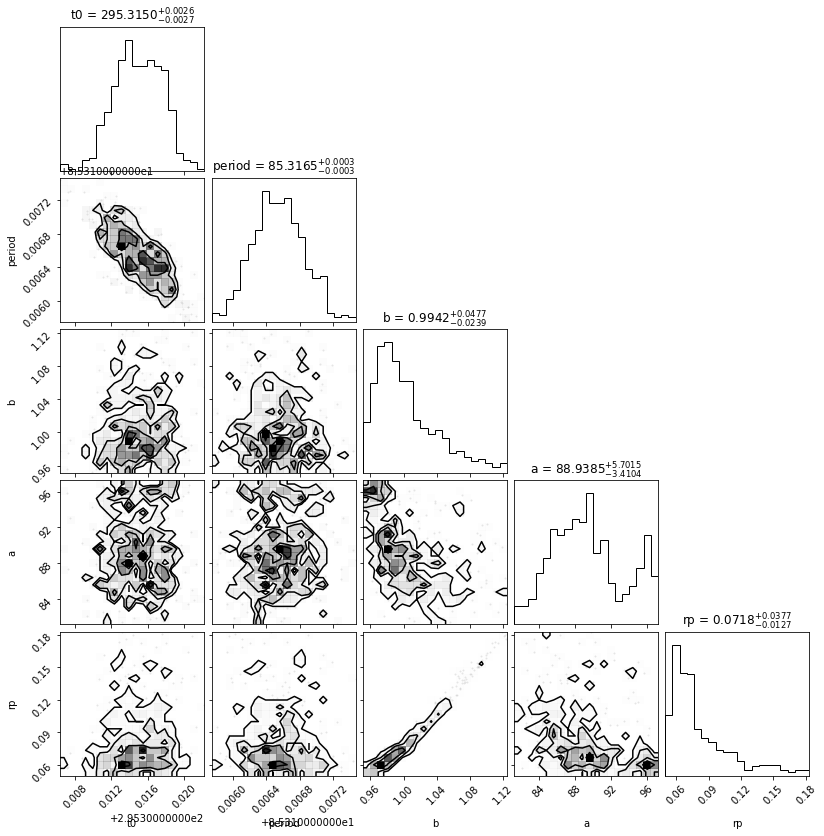

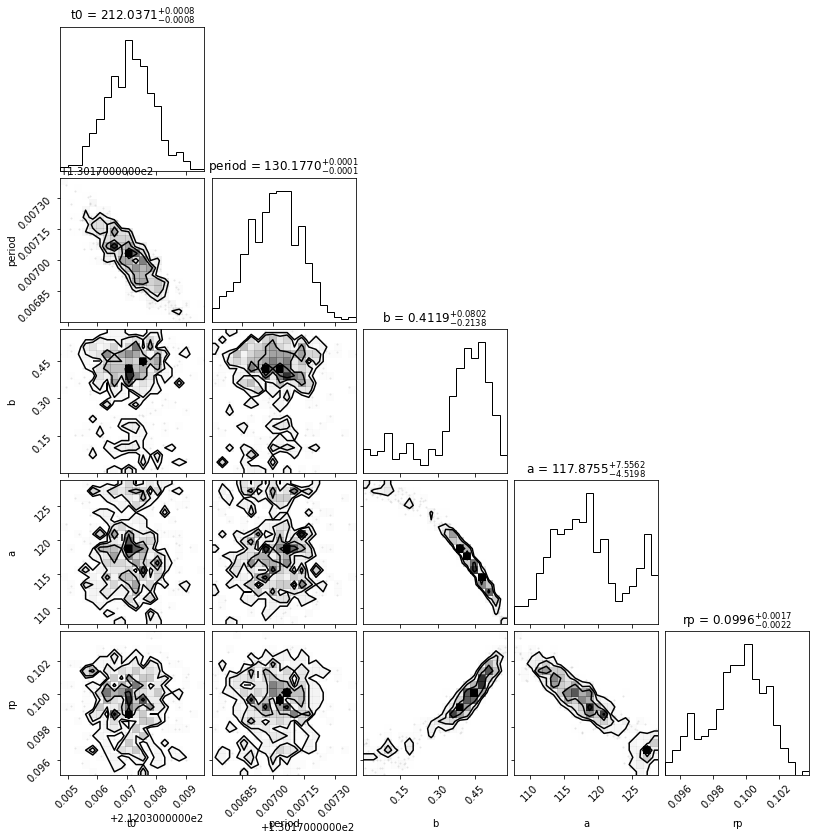

In [29]:
keys = ['t0', 'period', 'b', 'a', 'rp']
for j in range(len(dkoi)):
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k][:,j] for k in keys])))
    fig = corner.corner(hyper, labels=keys, show_titles=True, title_fmt=".4f")

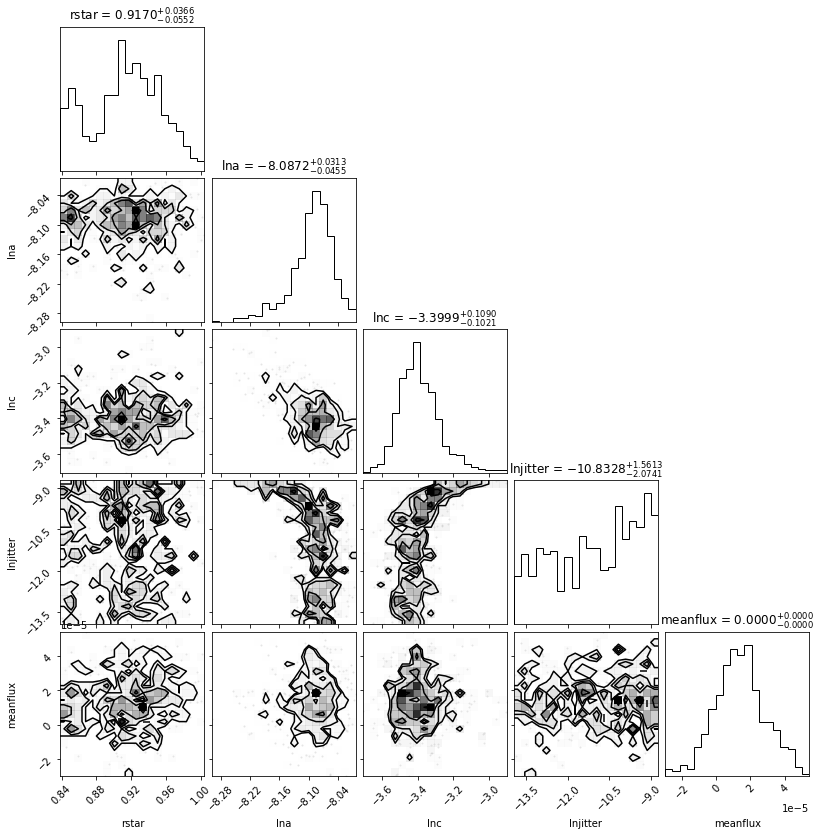

In [30]:
keys = ['rstar', 'lna', 'lnc', 'lnjitter', 'meanflux']
hyper = pd.DataFrame(data=dict(zip(keys, [samples[k] for k in keys])))
fig = corner.corner(hyper, labels=keys, show_titles=True, title_fmt=".4f")

## check model again

In [31]:
meanf = np.array(np.mean(samples['fluxmodel'], axis=0))

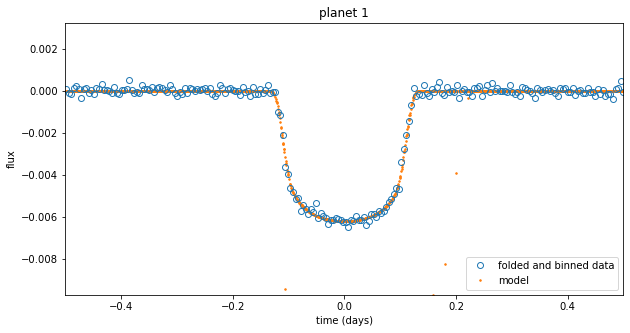

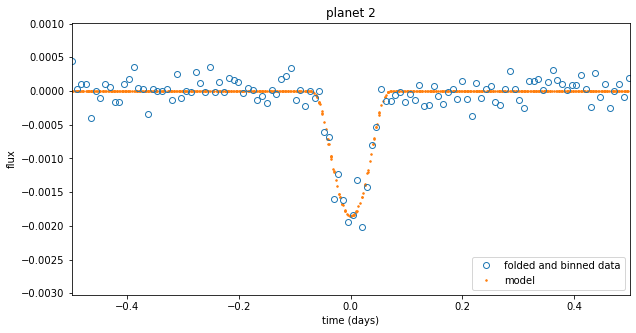

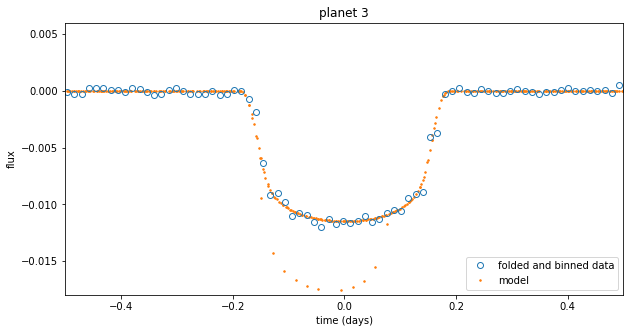

In [32]:
check_folded_transits(t, f, e, meanf, popt['t0'], popt['period'])